In [1]:
!pip install spacy
!pip install wordcloud
!python -m spacy download en_core_web_sm

  Using cached spacy-3.2.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.1 MB)
  Using cached blis-0.7.7-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached thinc-8.0.15-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (661 kB)
  Using cached wasabi-0.9.1-py3-none-any.whl (26 kB)
  Using cached typer-0.4.1-py3-none-any.whl (27 kB)
  Using cached spacy_legacy-3.0.9-py2.py3-none-any.whl (20 kB)
  Using cached cymem-2.0.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35 kB)
  Using cached catalogue-2.0.7-py3-none-any.whl (17 kB)
  Using cached srsly-2.4.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (457 kB)
  Using cached pathy-0.6.1-py3-none-any.whl (42 kB)
  Using cached spacy_loggers-1.0.2-py3-none-any.whl (7.2 kB)
  Using cached pydantic-1.8.2-cp39-cp39-manylinux2014_x86_64.whl (11.3 MB)
  Using cached murmurhash-1.0.6-cp39-cp39-manylinux_2_5_x86_64.many

In [2]:
import pandas as pd
import numpy as np
import spacy
import wordcloud
import matplotlib.pyplot as plt
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from spacy.lang.en.examples import sentences 



In [3]:
df=pd.read_csv("sample-data.csv")

In [4]:
display(df)
print(df.info())

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."
...,...,...
495,496,Cap 2 bottoms - Cut loose from the maddening c...
496,497,Cap 2 crew - This crew takes the edge off fick...
497,498,All-time shell - No need to use that morning T...
498,499,All-wear cargo shorts - All-Wear Cargo Shorts ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           500 non-null    int64 
 1   description  500 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB
None


In [5]:

#Cleaning sentences
df['clean_description'] = df['description'].str.replace(r"[^A-Za-z0-9 < > ]+", "")

df['clean_description'] = df['clean_description'].fillna('').apply(lambda x: x.lower())

mapping = [ ('</li>', ''), ('<li>', ''), ('</ul>', ''), ('<ul>', ''), ('<br>', ''), ('<b>', ''), ('</b>', ''),('<', ''),('>', '')]
for k, v in mapping:
    df['clean_description'] = df['clean_description'].str.replace(k, v)

liste_balise = [' li ',' ul ',' br ',' b ']

for x in liste_balise:
   df['clean_description'] = df['clean_description'].str.replace(x, ' ')


df = df.rename({'id':'item_id'},axis=1)



/tmp/ipykernel_111/4131405575.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_description'] = df['description'].str.replace(r"[^A-Za-z0-9 < > ]+", "")


In [6]:
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

## Tokenize the cleaned document
tokenized_doc = df['clean_description'].fillna('').apply(lambda x: nlp(x))

# remove stop-words and lemmatization
tokenized_doc = tokenized_doc.apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
tokenized_doc

0      [active, classic, boxer,  , s, reason, boxer, ...
1      [active, sport, boxer, brief,  , skin, glory, ...
2      [active, sport, brief,  , superbreathable, nof...
3      [alpine, guide, pant,  , skin, climb, ice, swi...
4      [alpine, wind, jkt,  , high, ridge, steep, ice...
                             ...                        
495    [cap, 2, bottom,  , cut, loose, madden, crowd,...
496    [cap, 2, crew,  , crew, take, edge, fickle, we...
497    [alltime, shell,  , need, use, morning, time, ...
498    [allwear, cargo, short,  , allwear, cargo, sho...
499    [allwear, short,  , time, simplify, allwear, s...
Name: clean_description, Length: 500, dtype: object

In [7]:
df["clean_token"] = tokenized_doc.apply(lambda x: ' '.join(x))
df

,item_id,description,clean_description,clean_token
0,1,Active classic boxers - There's a reason why o...,active classic boxers theres a reason why our...,active classic boxer s reason boxer cult fav...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory r...,active sport boxer brief skin glory require ...
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable nof...,active sport brief superbreathable nofly bri...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch t...,alpine guide pant skin climb ice switch rock...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and ...,alpine wind jkt high ridge steep ice alpine ...
...,...,...,...,...
495,496,Cap 2 bottoms - Cut loose from the maddening c...,cap 2 bottoms cut loose from the maddening cr...,cap 2 bottom cut loose madden crowd search u...
496,497,Cap 2 crew - This crew takes the edge off fick...,cap 2 crew this crew takes the edge off fickl...,cap 2 crew crew take edge fickle weather cle...
497,498,All-time shell - No need to use that morning T...,alltime shell no need to use that morning tim...,alltime shell need use morning time umbrella...
498,499,All-wear cargo shorts - All-Wear Cargo Shorts ...,allwear cargo shorts allwear cargo shorts bas...,allwear cargo short allwear cargo short bask...


In [8]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_token'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
df_TF_IDF = pd.DataFrame(dense, 
             columns=[x for x in vectorizer.get_feature_names()], 
             index=[x for x in range(1,501)] )
df_TF_IDF

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,06,07,08,09,10,100,100gram,101,102,1021,...,zipper,zippered,zipperedorganizer,zippersfabric,zipping,zippocket,zips,zipsecurity,zipthrough,zone
1,0.0,0.0,0.0,0.0,0.0,0.072153,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.263088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.048092,0.0,0.0,0.0,0.0,...,0.133134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.0,0.0,0.0,0.0,0.0,0.033162,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.066231,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.132104,0.0,0.0,0.0,0.0,...,0.036571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499,0.0,0.0,0.0,0.0,0.0,0.070397,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X=df_TF_IDF.values
scan = DBSCAN(eps = 0.735 ,min_samples=4 ,metric='cosine')
scan.fit(X)
df['cluster'] = scan.labels_
from collections import Counter
Counter(scan.labels_)


Counter({0: 47,
         -1: 47,
         1: 171,
         2: 29,
         3: 17,
         4: 19,
         5: 74,
         6: 7,
         7: 8,
         8: 3,
         9: 7,
         10: 7,
         11: 24,
         14: 4,
         12: 5,
         13: 12,
         15: 7,
         16: 4,
         17: 4,
         18: 4})

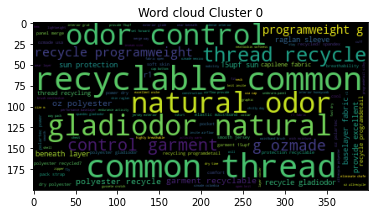

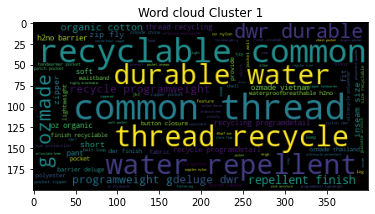

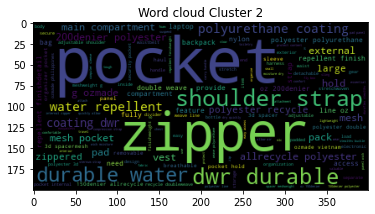

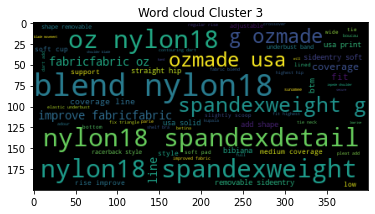

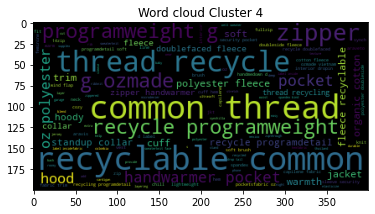

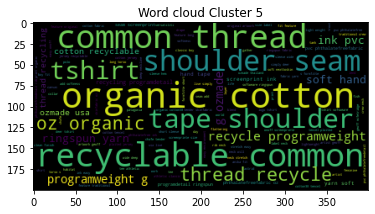

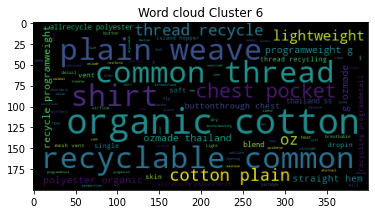

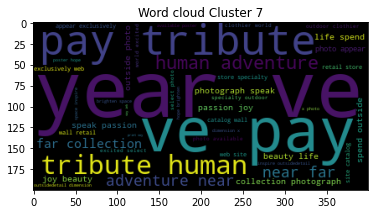

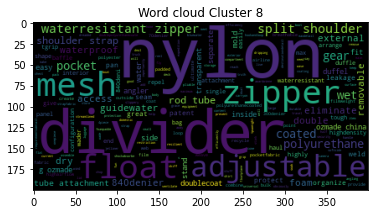

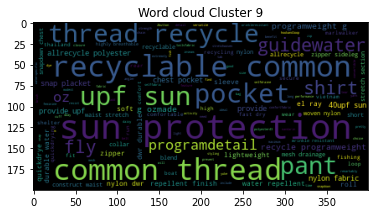

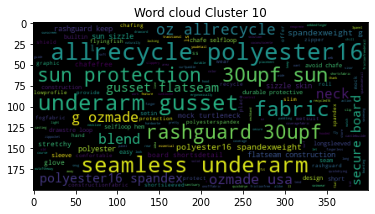

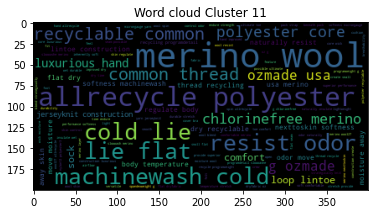

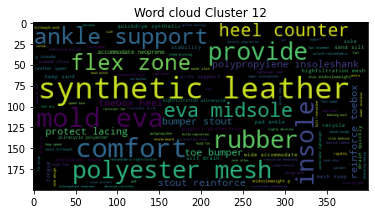

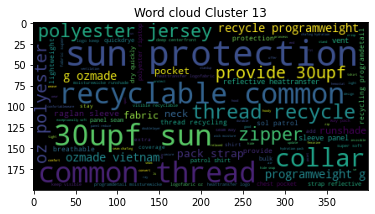

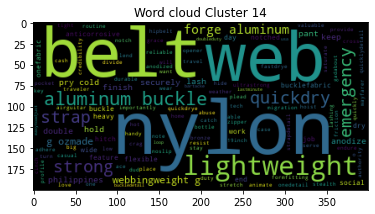

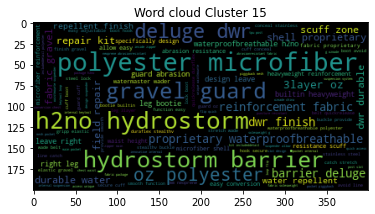

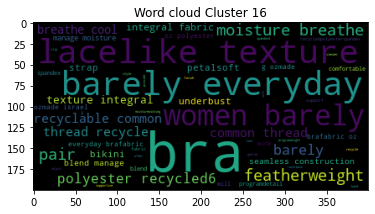

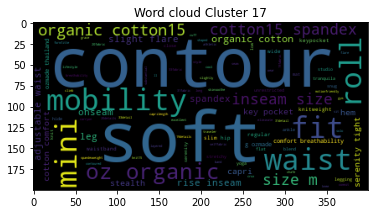

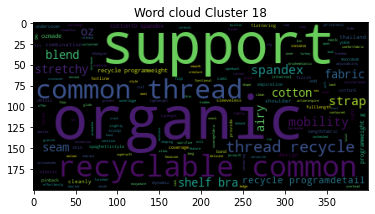

In [11]:
wd = wordcloud.WordCloud()

for i in range(len(np.unique(scan.labels_))-1):
    corpus=[]
    for x in df['clean_token'][df['cluster']==i]:
        corpus.append(x)
        
    to_cloud = ' '.join(corpus)
    cloud = wd.generate(to_cloud)
    plt.title(f'Word cloud Cluster {i}')
    plt.imshow(cloud)
    plt.show()



In [12]:
def find_similar_items(item_id):
    item_cluster = df[df['item_id']==int(item_id)]['cluster'].iloc[0]
    df_cluster_fonction = df[df['cluster']==item_cluster]
    return df_cluster_fonction.sample(n=5)[['item_id','description','cluster']]

In [13]:
condition = True 
while condition == True:
    item_id=input('Tap a item id between 1 to 500:')

    if str(item_id).isnumeric()==False:
        condition=True

    elif int(item_id) <1 or int(item_id) >500:
        condition=True
    
    else: 
        display(find_similar_items(item_id))
        condition=False


Tap a item id between 1 to 500: 498


,item_id,description,cluster
183,184,"Guide jkt - Sharp granite, sticky verglas, unt...",1
32,33,Deep wading jkt - Whether you're chasing Olymp...,1
206,207,"Multi use shorts - Streamlined, technical and ...",1
478,479,"Bimini cap - South of Kanab, temperatures take...",1
146,147,"Ultra shorts - Our ever-popular long-cut, quic...",1


In [14]:
svd_model = TruncatedSVD(n_components=14,n_iter=100 ,algorithm='randomized')
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa,columns=[f'topic_{x}' for x in range(1,15)])
topic_encoded_df["documents"] = df['clean_token']
topic_encoded_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,documents
0,0.244505,-0.049273,0.152927,0.116001,-0.115815,-0.037819,0.029426,-0.073981,-0.094826,-0.021661,-0.025716,0.001075,0.030135,0.053596,active classic boxer s reason boxer cult fav...
1,0.212282,-0.066017,0.078060,0.100006,-0.038420,0.028631,0.031753,-0.047312,-0.013202,-0.051301,-0.058543,0.178825,-0.033371,-0.004502,active sport boxer brief skin glory require ...
2,0.196287,-0.068445,0.088449,0.046803,-0.040433,0.069578,0.010838,0.030776,-0.000745,-0.034581,-0.020605,0.208032,-0.062834,-0.022777,active sport brief superbreathable nofly bri...
3,0.317251,-0.234266,-0.092111,-0.096494,0.013542,-0.044587,0.003468,-0.091189,0.010168,-0.064416,-0.169208,0.023908,0.079651,-0.003202,alpine guide pant skin climb ice switch rock...
4,0.349125,-0.254947,-0.018324,-0.211433,-0.038414,-0.016695,-0.047573,-0.000426,0.089400,-0.026633,-0.153285,0.020592,0.142638,0.192961,alpine wind jkt high ridge steep ice alpine ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.322552,-0.079321,0.364464,0.109788,-0.284454,-0.075576,-0.001403,-0.151215,-0.273225,-0.095447,-0.051666,0.009372,0.091765,-0.012077,cap 2 bottom cut loose madden crowd search u...
496,0.336105,-0.068486,0.466971,0.028182,-0.316739,-0.045666,0.025257,-0.014672,-0.207247,-0.048885,0.019903,-0.042277,0.126142,-0.000306,cap 2 crew crew take edge fickle weather cle...
497,0.285219,-0.200607,-0.060594,-0.241578,0.013992,-0.069373,-0.249082,-0.020165,-0.016162,0.054006,0.059774,-0.131589,-0.076553,-0.048666,alltime shell need use morning time umbrella...
498,0.305726,0.051494,-0.172480,0.303742,0.060388,-0.132050,0.056322,0.039563,-0.077965,-0.018882,0.023722,-0.139713,-0.125079,0.013306,allwear cargo short allwear cargo short bask...


In [15]:
topic_df = pd.DataFrame(data=svd_model.components_,index = [f'topic_{x}' for x in range(1,15)] , columns = [x for x in vectorizer.get_feature_names()] )
topic_df

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,06,07,08,09,10,100,100gram,101,102,1021,...,zipper,zippered,zipperedorganizer,zippersfabric,zipping,zippocket,zips,zipsecurity,zipthrough,zone
topic_1,0.000395,0.000586,0.000651,0.000276,0.033953,0.149231,0.002117,0.002499,0.002154,0.000377,...,0.132372,0.025966,0.000608,0.000896,0.001912,0.000621,0.005013,0.001225,0.006143,0.008081
topic_2,-0.000197,-0.000230,-0.000218,-0.000279,-0.002975,0.055791,-0.003011,-0.001906,-0.001202,-0.000509,...,-0.154605,-0.033808,-0.000925,-0.001307,-0.002805,-0.000721,-0.006688,-0.001302,-0.005628,-0.012346
topic_3,0.000577,0.000661,0.000882,0.000563,-0.052114,-0.013379,-0.000521,-0.001016,-0.000367,-0.000209,...,-0.075085,-0.023324,-0.000774,-0.000357,-0.001978,0.000836,-0.004008,-0.001504,0.000768,-0.000713
topic_4,0.000486,0.000029,0.000610,0.000207,0.092197,-0.056033,-0.004878,0.001232,0.000491,-0.000786,...,-0.151248,-0.035583,-0.001585,-0.002056,-0.005451,0.000122,-0.009677,0.002516,-0.006950,-0.020556
topic_5,0.000296,-0.000330,0.000171,0.000228,0.011786,-0.061802,0.001005,-0.001638,0.000728,-0.000016,...,-0.006175,0.008488,0.000365,0.000331,0.000839,-0.000750,0.001188,0.000158,-0.006859,0.017595
topic_6,0.001798,0.001694,0.001323,0.001910,-0.033350,-0.021825,-0.002265,-0.000858,0.001317,0.000408,...,-0.045476,-0.000739,0.000556,0.001443,-0.002256,0.002847,-0.003119,-0.000631,-0.006086,0.009420
topic_7,-0.000787,0.001685,-0.000828,-0.000354,-0.005274,0.040554,-0.001606,0.000978,-0.006845,0.002088,...,-0.019265,0.034814,0.003806,0.005583,-0.007590,0.001468,-0.012147,0.002994,-0.016679,-0.023479
topic_8,0.000484,-0.001171,0.000374,0.000846,0.004740,0.054505,0.004892,0.000182,-0.000267,0.002061,...,0.045851,0.024476,0.003211,0.005841,-0.001035,-0.002140,-0.002388,-0.004316,0.012577,-0.011622
topic_9,0.000846,0.003902,0.001430,0.000384,-0.056547,-0.037732,0.002490,0.003422,0.000591,-0.001142,...,0.010217,-0.005347,-0.001984,-0.002342,-0.000131,0.008728,0.000884,0.000282,0.017266,-0.046025
topic_10,-0.000372,0.002468,-0.000419,-0.000221,0.013471,0.031544,-0.001407,-0.001793,0.000251,-0.000065,...,-0.017862,-0.011844,-0.000194,-0.000669,0.001675,0.004731,0.004895,-0.001044,-0.001358,0.012861


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


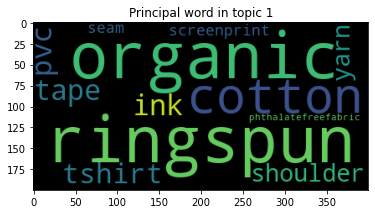

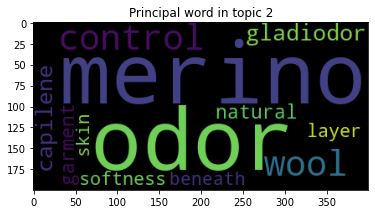

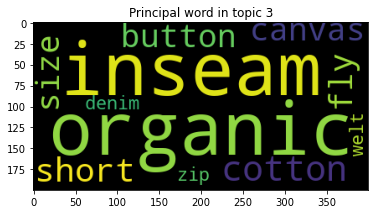

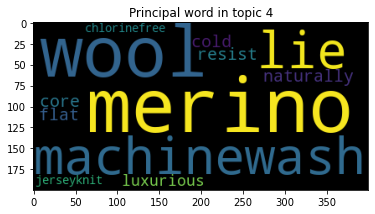

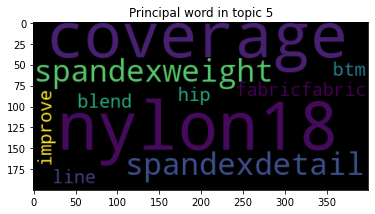

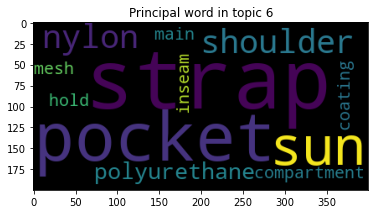

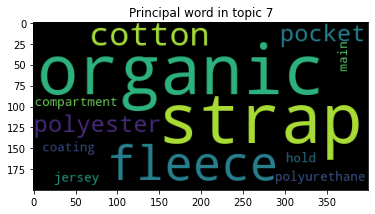

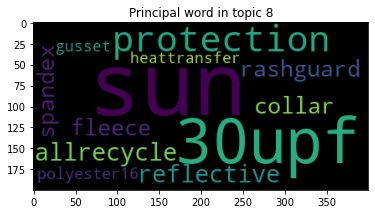

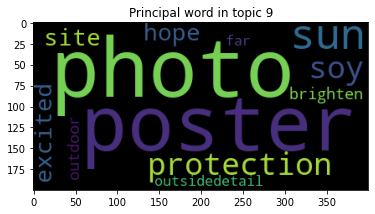

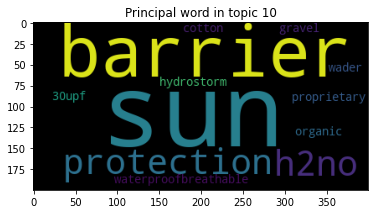

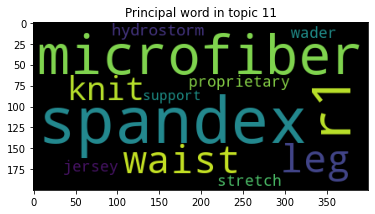

In [16]:
num_top_words=12
vocab = np.array(vectorizer.get_feature_names())

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

topic_word = show_topics(svd_model.components_)
for x in range(1,12):
    to_cloud = ''.join(topic_word[x] )
    cloud = wd.generate(to_cloud)
    plt.title(f'Principal word in topic {x}')
    plt.imshow(cloud)
    plt.show()
